<a href="https://colab.research.google.com/github/JTStephens18/AudioTranscriptor/blob/main/VisionEncDec_audioProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install yt-dlp
# Install huggingface audio datasets
! pip install datasets[audio]
! pip install transformers evaluate jiwer
!pip install accelerate -U
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [197]:
from datasets import load_dataset, Audio, Dataset
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor, AutoTokenizer, AutoProcessor
import subprocess
import os
from pathlib import Path
import torch
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
ds = load_dataset('google/MusicCaps', split="train")
ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['ytid', 'start_s', 'end_s', 'audioset_positive_labels', 'aspect_list', 'caption', 'author_id', 'is_balanced_subset', 'is_audioset_eval'],
    num_rows: 5521
})

In [ ]:
ds

Dataset({
    features: ['ytid', 'start_s', 'end_s', 'audioset_positive_labels', 'aspect_list', 'caption', 'author_id', 'is_balanced_subset', 'is_audioset_eval'],
    num_rows: 5521
})

In [4]:
ds = ds.remove_columns(["author_id", "is_balanced_subset", "is_audioset_eval", "audioset_positive_labels"])

In [5]:
df = pd.read_csv("./spectrograms.csv")
df["filename"] = df['filename'].str.replace("'", '')
df["filename"] = df['filename'].apply(lambda x: x.split('.')[0])

In [6]:
# new_ds = []
# for item in ds:
#   if item["ytid"] in df.values:
#     print(item["ytid"])
#     new_ds.append(item)
#     new_ds = Dataset.from_pandas(new_ds)


ds_df = ds.to_pandas()

ytid_set = set(df['filename'])
filtered_df = ds_df[ds_df['ytid'].isin(ytid_set)]
ds = Dataset.from_pandas(filtered_df)

In [ ]:
ds

Dataset({
    features: ['ytid', 'start_s', 'end_s', 'aspect_list', 'caption', '__index_level_0__'],
    num_rows: 1579
})

In [7]:
ds = ds.train_test_split(test_size=0.2)

In [8]:
processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base")

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [176]:
def download_clip(
    video_id,
    output_filename,
    start_time,
    end_time,
    tmp_dir='/musiccaps',
    num_attempts=5,
    url_base='https://www.youtube.com/watch?v='
):

  status = False
  command = f"""
        yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "{output_filename}" --download-sections "*{start_time}-{end_time}" {url_base}{video_id} --force-keyframes-at-cuts
    """.strip()
  attempts = 0
  while True:
    try:
      # output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
      output = os.system(command)
    except subprocess.CalledProcess.Error as err:
      attempts += 1
      if attempts == num_attempts:
        return status, err.output
    else:
      break

  # Check if video was successfully saved
  status = os.path.exists(output_filename)
  return status, 'Downloaded'


def toUppercase(aspect_list):
  a_list = aspect_list[1:-1]
  new_list = ''
  for word in a_list:
    new_list = ''.join(a_list).upper().replace(',', '')
    # new_list = new_list.replace(' ', '|')
    if(len(new_list) > 128):
      new_list = new_list[:128]
  return new_list


def process(example):
  output_path = str(data_dir / f"{example['ytid']}.wav")
  status = True
  aspect_string = toUppercase(example['aspect_list'])
  if not os.path.exists(output_path):
    status = False
    status, log = download_clip(
        example['ytid'],
        output_path,
        example['start_s'],
        example['end_s'],
    )

  example['aspect_string'] = aspect_string
  example["audio"] = output_path
  example['download_status'] = status
  example["image_path"] = f'./spectrograms/{example["ytid"]}.png'
  return example

In [ ]:
def process_input_length(example):
  audio = example["audio"]
  example = processor(audio['array'], sampling_rate=audio["sampling_rate"], text=example['aspect_string'])
  # example["input_length"] = len(example["input_values"][0])
  return example

In [ ]:
samples_to_load = 30
cores = 4
sampling_rate = 16000
writer_batch_size = 1000
data_dir = "./music_data"

ds_train = ds["train"].select(range(samples_to_load))
ds_test = ds["test"].select(range(int(samples_to_load*0.2)))

# ds_train = ds["train"]
# ds_test = ds["test"]

data_dir = Path(data_dir)
data_dir.mkdir(exist_ok=True, parents=True)

ds_train = ds_train.map(
    process,
    num_proc=cores,
    writer_batch_size=writer_batch_size,
    keep_in_memory=False
)


ds_train_audio = ds_train.filter(lambda ex: ex["download_status"] == True)
# ds_train_audio = ds_train_audio.cast_column('audio', Audio(sampling_rate=sampling_rate))

# ds_train_final = ds_train_audio.map(
#     process_input_length,
#     num_proc=1,
#     writer_batch_size=writer_batch_size,
#     keep_in_memory=False
# )

ds_train_final = ds_train_audio

ds_test = ds_test.map(
    process,
    num_proc=cores,
    writer_batch_size=writer_batch_size,
    keep_in_memory=False
)

ds_test_audio = ds_test.filter(lambda ex: ex["download_status"] == True)
# ds_test_audio = ds_test_audio.cast_column('audio', Audio(sampling_rate=sampling_rate))

# ds_test = ds_test_audio.map(
#     process_input_length,
#     num_proc=1,
#     writer_batch_size=writer_batch_size,
#     keep_in_memory=False
# )

ds_test = ds_test_audio

Map (num_proc=4):   0%|          | 0/30 [00:00<?, ? examples/s]

Filter:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/6 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

In [ ]:
import wave
# wave = wave.open("./music_data/4PGzlwvXMnE.wav")
# wave.getnchannels()
wave2 = wave.open("./music_data/DYpjbiyPUho.wav", 'wb')
wave2.setnchannels(1)
wave2.getnchannels()

1

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read("./music_data/3u9OO9Og0Gc.wav")
print(sample_rate)
new_samples = np.zeros(samples.shape[0])

# for i in range(samples.shape[0]):
#   l_sample = int(samples[i][0])
#   r_sample = int(samples[i][1])
#   avg_sample = (l_sample + r_sample) / 2
#   new_samples[i] = avg_sample


48000


In [ ]:
samples[0]
print(new_samples.shape)
print(new_samples[8])

(480000,)
-2613.5


In [ ]:
!pip install pydub
from pydub import AudioSegment

In [ ]:
sound = AudioSegment.from_wav("./music_data/DPW5M1FYxu4.wav")
sound = sound.set_channels(1)
sound.export("./music_data/1_DPW5M1FYxu4.wav", format='wav')

<_io.BufferedRandom name='./music_data/1_DPW5M1FYxu4.wav'>

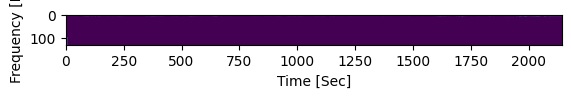

<Figure size 1400x500 with 0 Axes>

In [ ]:
sample_rate, samples = wavfile.read("./music_data/DPW5M1FYxu4.wav")
frequencies, times, spectrogram = signal.spectrogram(samples[:,0], sample_rate)

plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel("Time [Sec]")
plt.figure(figsize=(14, 5))
plt.show()

In [ ]:
import librosa
import librosa.display
from scipy.io import wavfile
from tempfile import mktemp

def plot_mat(file):
  x, sr = librosa.load(file, sr=44100)
  plt.figure(figsize=(14, 5))
  librosa.display.waveplot(x, sr=sr)


def convert_audio_to_spectrogram(file):
  x, sr = librosa.load(file, sr=44100)
  X = librosa.stft(x)
  Xdb = librosa.amplitude_to_db(abs(X))

  plt.figure(figsize=(14,5))
  # librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
  librosa.display.specshow(Xdb, sr=sr)
  # plt.colorbar()
  plt.savefig('tester2.png', bbox_inches='tight')


def convert_audio_to_spectrogram_log(file):
  x, sr = librosa.load(file, sr=44100)
  X = librosa.stft(x)
  Xdb = librosa.amplitude_to_db(abs(X))

  plt.figure(figsize=(14,5))
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
  plt.colorbar()

In [ ]:
def audio_to_spec(file):
  x, sr = librosa.load(file, sr=44100)
  X = librosa.stft(x)
  Xdb = librosa.amplitude_to_db(abs(X))

  fig = plt.figure(figsize=(14,5))
  librosa.display.specshow(Xdb, sr=sr)
  newFilename = file[13:].split('.')
  plt.savefig(f'./spectrograms/{newFilename[0]}.png', bbox_inches='tight')
  plt.close(fig)

In [ ]:
def test_filename(file):
  newfile = file[13:].split('.')
  print(newfile)
  return newfile

In [128]:
count = 0
for path in os.listdir("./spectrograms"):
  if os.path.isfile(os.path.join("./spectrograms", path)):
    count+=1

print(count)

1579


In [10]:
!unzip spectrograms.zip

Archive:  spectrograms.zip
   creating: spectrograms/.ipynb_checkpoints/
  inflating: spectrograms/-_6RxZyi30Q.png  
  inflating: spectrograms/-_OzT7Xyvok.png  
  inflating: spectrograms/0_hH79HnEdo.png  
  inflating: spectrograms/0_QcatLmg7c.png  
  inflating: spectrograms/0_XItMAYkwc.png  
  inflating: spectrograms/00M9FhCet6s.png  
  inflating: spectrograms/01hjVJN9xCg.png  
  inflating: spectrograms/01PzcPKT3_E.png  
  inflating: spectrograms/0298WjE3_tk.png  
  inflating: spectrograms/02Qntw26enM.png  
  inflating: spectrograms/03frQGyrgQ4.png  
  inflating: spectrograms/03z0rpIkm5g.png  
  inflating: spectrograms/04NjXsLyCl4.png  
  inflating: spectrograms/05JAmKFVy44.png  
  inflating: spectrograms/05OJDYeHLMc.png  
  inflating: spectrograms/06Brdf83RZE.png  
  inflating: spectrograms/06IU9WsEp3s.png  
  inflating: spectrograms/07-3grCQ8EU.png  
  inflating: spectrograms/07FxCXxknY4.png  
  inflating: spectrograms/07mS0mSTDjY.png  
  inflating: spectrograms/0-7PyzhzuYQ.png  
  i

In [177]:
samples_to_load = 1000
cores = 4
sampling_rate = 16000
writer_batch_size = 1000
data_dir = "./music_data"
upper_limit = 1600
lower_limit = 800

data_dir = Path(data_dir)
data_dir.mkdir(exist_ok=True, parents=True)

# ds = ds.select(range(lower_limit, upper_limit))

# ds = ds.map(
#     process,
#     num_proc=cores,
#     writer_batch_size=writer_batch_size,
#     keep_in_memory=False
# )


# ds = ds.filter(lambda ex: ex["download_status"] == True)

ds_train = ds["train"].select(range(samples_to_load))
ds_test = ds["test"].select(range(int(samples_to_load*0.2)))

ds_train = ds_train.map(
    process,
    num_proc=cores,
    writer_batch_size=writer_batch_size,
    keep_in_memory=False,
    # batched=True,
)

ds_train = ds_train.filter(lambda ex: ex["download_status"] == True)

ds_test = ds_test.map(
    process,
    num_proc=cores,
    writer_batch_size=writer_batch_size,
    keep_in_memory=False,
    # batched=True,
)

ds_test = ds_test.filter(lambda ex: ex["download_status"] == True)

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

In [12]:
ds_train[0]

{'ytid': '76ON0Ixrr9s',
 'start_s': 30,
 'end_s': 40,
 'aspect_list': "['low quality', 'mono', 'noisy', 'fading out', 'electric guitar melody', 'echoing effect', 'psychedelic']",
 'caption': 'The low quality recording features an electric guitar melody playing. The melody fades out in the beginning and it starts playing again in the second part of the loop, where it has an echoing effect on. It gives off psychedelic vibes. The recording is noisy and in mono.',
 '__index_level_0__': 811,
 'aspect_string': "'LOW QUALITY' 'MONO' 'NOISY' 'FADING OUT' 'ELECTRIC GUITAR MELODY' 'ECHOING EFFECT' 'PSYCHEDELIC'",
 'audio': 'music_data/76ON0Ixrr9s.wav',
 'download_status': True,
 'image_path': './spectrograms/76ON0Ixrr9s.png'}

In [ ]:
df = pd.read_csv("./spectrograms.csv")
df["filename"] = df['filename'].str.replace("'", '')
df["filename"] = df['filename'].apply(lambda x: x.split('.')[0])
print(df.shape)
print(ds[103])
if '-wymN80CiYU' not in df.values:
  print('true')

(791, 1)
{'ytid': '8FZb_R2UANY', 'start_s': 90, 'end_s': 100, 'aspect_list': "['pop', 'low quality', 'electric guitar melody', 'shimmering hi hats', 'groovy bass', 'sustained strings melody', 'pulsating synth melody', 'punchy kick', 'echoing synth bell melody', 'emotional', 'passionate', 'cinematic', 'background music']", 'caption': 'The low quality recording features a pop song that consists of an electric guitar melody, shimmering hi hats, groovy bass, sustained strings melody, pulsating synth melody, punchy kick and echoing synth bell melody. It sounds emotional, passionate and cinematic, as it also sounds like something that would go well as a background music for movies.', 'aspect_string': "'POP'|'LOW|QUALITY'|'ELECTRIC|GUITAR|MELODY'|'SHIMMERING|HI|HATS'|'GROOVY|BASS'|'SUSTAINED|STRINGS|MELODY'|'PULSATING|SYNTH|MELODY'|'PUNCHY|KICK'|'ECHOING|SYNTH|BELL|MELODY'|'EMOTIONAL'|'PASSIONATE'|'CINEMATIC'|'BACKGROUND|MUSIC'", 'audio': 'music_data/8FZb_R2UANY.wav', 'download_status': True}

In [ ]:
for i in range(ds.shape[0]):
  if ds[i]["ytid"] not in df.values:
    id = "./music_data/" + ds[i]["ytid"] + '.wav'
    print(id)
    audio_to_spec(id)

In [ ]:
!zip -r ./spectrograms.zip ./spectrograms

In [124]:
# Deletes spectrograms folder
!rm -rf spectrograms

In [ ]:
from google.colab import files
files.download('./spectograms.zip')

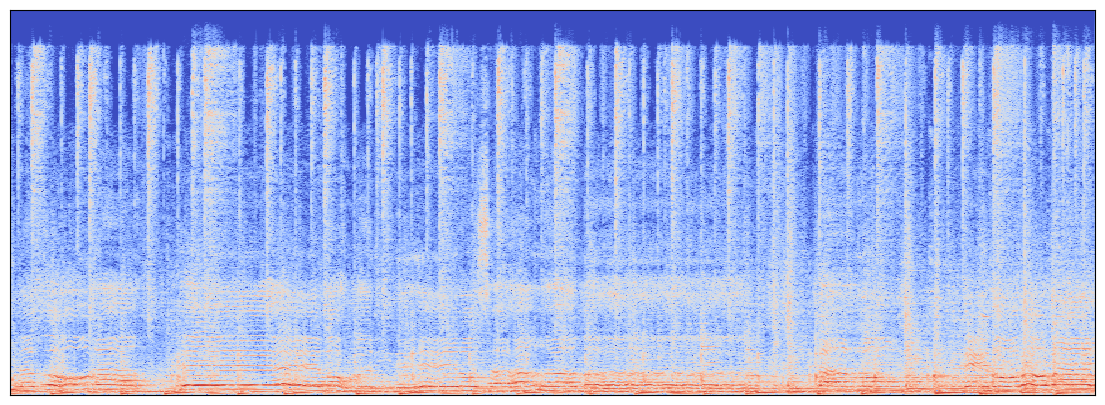

In [ ]:
convert_audio_to_spectrogram("./music_data/DPW5M1FYxu4.wav")

In [13]:
image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decode_model = "gpt2"

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    image_encoder_model, text_decode_model
)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.1.crossattention.c_proj.weight', 'h.6.ln_cross_attn.weight', 'h.8.crossattention.q_attn.weight', 'h.1.crossattention.q_attn.weight', 'h.9.ln_cross_attn.weight', 'h.11.crossattention.c_attn.weight', 'h.8.ln_cross_attn.weight', 'h.9.crossattention.c_attn.weight', 'h.7.ln_cross_attn.bias', 'h.1.crossattention.q_attn.bias', 'h.3.crossattention.c_attn.weight', 'h.9.ln_cross_attn.bias', 'h.11.crossattention.c_proj.bias', 'h.8.ln_cross_attn.bias', 'h.7.crossattention.c_proj.weight', 'h.5.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.6.crossattention.q_attn.bias', 'h.2.crossattention.q_attn.bias', 'h.6.crossattention.c_attn.bias', 'h.2.crossattention.c_proj.weight', 'h.6.ln_cross_attn.bias', 'h.7.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.weight', 'h.5.crossattention.c_attn.bias', 'h.5.ln_cross_attn.bias', 'h.4.ln

In [14]:
feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)
tokenizer = AutoTokenizer.from_pretrained(text_decode_model)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [15]:
tokenizer.pad_token = tokenizer.eos_token

model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [16]:
output_dir = "vit-gpt-model"
model.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('vit-gpt-model/tokenizer_config.json',
 'vit-gpt-model/special_tokens_map.json',
 'vit-gpt-model/vocab.json',
 'vit-gpt-model/merges.txt',
 'vit-gpt-model/added_tokens.json',
 'vit-gpt-model/tokenizer.json')

In [194]:
from PIL import Image

def tokenization_fn(captions, max_target_length, examples):
  labels = tokenizer(captions, padding="max_length", max_length=max_target_length).input_ids
  return labels
  # result = tokenizer(captions, max_length=max_target_length, return_overflowing_tokens=True)
  # sample_map = result.pop("overflow_to_sample_mapping")
  # for key, values in examples.items():
  #   # result[key] = [values[i] for i in sample_map]
  #   result[key] = [examples.get(i) for i in sample_map]
  # return result


def feature_extraction_fn(image_paths, check_image=True):
  model_inputs = {}

  if check_image:
    images = []
    to_keep = []
    # for image_file in image_paths:
      # print(image_file)
    try:
      print("try")
      # img = Image.open(image_file).convert("RGB")
      img = Image.open(image_paths).convert("RGB")
      print("append")
      images.append(img)
      to_keep.append(True)
    except Exception:
      to_keep.append(False)
  else:
    # images = [Image.open(image_file) for image_file in image_paths]
    images = [Image.open(image_paths).convert("RGB")]

  # print(images)
  encoder_inputs = feature_extractor(images=images, return_tensors="np")

  return encoder_inputs.pixel_values


def preprocess_fn(examples, max_target_length, check_image=False):
  image_paths = examples["image_path"]
  captions = examples["aspect_string"]

  model_inputs = {}

  model_inputs['labels'] = tokenization_fn(captions, max_target_length, examples)
  model_inputs["pixel_values"] = feature_extraction_fn(image_paths, check_image=check_image)
  model_inputs["pixel_values"] = np.squeeze(model_inputs["pixel_values"])

  return model_inputs

In [115]:
# img_path = ds_train[0]["image_path"]
# for image_file in img_path:
#   print(img_path)
testing = preprocess_fn(ds_train[0], 128)

try
append
[<PIL.Image.Image image mode=RGB size=1105x405 at 0x7B860D383A00>]


In [195]:
processed_dataset_train = ds_train.map(
    function=preprocess_fn,
    # batched=True,
    fn_kwargs={"max_target_length": 128}
)

processed_dataset_test = ds_test.map(
    function=preprocess_fn,
    # batched=True,
    fn_kwargs={"max_target_length": 128}
)

Map:   0%|          | 0/998 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [123]:
os.path.isfile('./spectrograms/8LYWfpPUokc.png')

False

In [19]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    output_dir="./image-captioning-output",
)

In [20]:
# ! pip install evaluate
! pip install rouge_score
import evaluate
metric = evaluate.load('rouge')
# from rouge_score import rouge_scorer

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=7eeeb02e6de1f89feebb9a73765346190dacbe0525c53c0f58a2e84a139bddc0
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [21]:
ignore_pad_token_for_loss = True

def postprocess_text(preds, labels):
  preds = [pred.strip() for pred in preds]
  labels = [label.strip() for label in labels]

  preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
  labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

  return preds, labels


def compute_metrics(eval_preds):
  preds, labels = eval_preds
  if isinstance(preds, tuple):
    preds = preds[0]
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  if ignore_pad_token_for_loss:
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

  result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
  result = {k: round(v*100, 4) for k, v in result.items()}
  prediction_lens = [
      np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
  ]
  result["gen_len"] = np.mean(prediction_lens)
  return result

In [163]:
print(len(processed_dataset_train[2]["labels"]))

211


In [198]:
from transformers import default_data_collator, DataCollatorWithPadding

# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
data_collator = default_data_collator

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset_train,
    eval_dataset=processed_dataset_test,
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,0.657085,7.286200,3.483400,6.891400,6.947200,19.000000
2,0.619200,0.626999,8.203400,3.483400,7.715100,7.769700,19.000000
3,0.619200,0.618774,8.203400,3.483400,7.715100,7.769700,19.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=750, training_loss=0.6009469807942708, metrics={'train_runtime': 5668.6601, 'train_samples_per_second': 0.528, 'train_steps_per_second': 0.132, 'total_flos': 5.403088900136632e+17, 'train_loss': 0.6009469807942708, 'epoch': 3.0})

In [222]:
ds_test[90]
file = "./spectrograms/3jLef5eHgzU.png"
image = Image.open(file).convert("RGB")
pixel_values = feature_extractor(images=image, return_tensors="np").pixel_values
print(pixel_values.shape)
# pixel_values = np.squeeze(pixel_values)
# print(pixel_values.shape)
pixel_values = torch.from_numpy(pixel_values)
gen_ids = model.generate(pixel_values)
print(gen_ids)
gen_text = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)[0]
print(gen_text)

(1, 3, 224, 224)
tensor([[50256,     6,    43,  3913, 19604,  1847,  9050,     6,   705, 15285,
          1797,    56,     6,   705, 27857,    46,     6,   705, 47924,  2849]])
'LOW QUALITY' 'NOISY' 'MONO' 'PASSION


In [224]:
print(ds_test[90])

{'ytid': '3jLef5eHgzU', 'start_s': 30, 'end_s': 40, 'aspect_list': "['amateur recording', 'comedic', 'crowd laughing', 'digital soundeffects', 'e-guitar', 'acoustic drums', 'e-bass', 'medium tempo', 'ecstatic']", 'caption': 'This audio contains someone playing a distorted e-guitar solo in a higher register along with acoustic drums with cymbal hits and a half open hit. An e-bass is underlining the rhythm. There are digital comedic noises and laughter that seem not to be part of the musical composition. This song may be playing in a comedic tv-show.', '__index_level_0__': 493, 'aspect_string': "'AMATEUR RECORDING' 'COMEDIC' 'CROWD LAUGHING' 'DIGITAL SOUNDEFFECTS' 'E-GUITAR' 'ACOUSTIC DRUMS' 'E-BASS' 'MEDIUM TEMPO' 'ECSTA", 'audio': 'music_data/3jLef5eHgzU.wav', 'download_status': True, 'image_path': './spectrograms/3jLef5eHgzU.png'}


In [181]:
+# data = trainer.train_dataset[0]
# print(len(data["labels"]))
# tokenizer.decode(data["labels"])
# data.keys()
# trainer.train_dataset.features['labels'].names

for i in range(30):
  print(len(trainer.train_dataset[i]["labels"]))

128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128


In [175]:
string = trainer.train_dataset[2]["aspect_string"]
test_string = string[:128]
print(len(test_string))

128


In [183]:
dataloader = trainer.get_train_dataloader()
dataloader.dataset[0]["pixel_values"]
# print(len(dataloader.dataset[0]["labels"]))

AttributeError: ignored

In [184]:
# Manually form a batch from the training set
for batch in trainer.get_train_dataloader():
  print(batch["pixel_values"].shape)
  break

torch.Size([4, 1, 3, 224, 224])


In [191]:
batch["pixel_values"].shape
testingval = batch["pixel_values"]
testingval1 = torch.squeeze(testingval)
print(testingval1.shape)

torch.Size([4, 3, 224, 224])


In [97]:
# Check what collate function the dataloader is using
data_collator = trainer.get_train_dataloader().collate_fn
data_collator

<function transformers.data.data_collator.default_data_collator(features: List[transformers.data.data_collator.InputDataClass], return_tensors='pt') -> Dict[str, Any]>

In [68]:
# Apply data collator on a few batches of data
# actual_train_set = trainer.remove_unused_columns(trainer.train_dataset)
batch = data_collator([trainer.train_dataset[i] for i in range(4)])

ValueError: ignored

In [ ]:
# audio_sample = ds_train_final[0]["audio"]["array"]
# test_output_path = "output.wav"
# sf.write(test_output_path, audio_sample, 16000)
# ds_train[0]["ytid"]

'ciJOulWFhfA'

In [ ]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
  processor: AutoProcessor
  padding: Union[bool, str] = 'longest'

  def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
    input_features = [{"input_values": feature["input_values"][0]} for feature in features]
    label_features = [{"input_ids": feature["labels"]} for feature in features]

    batch = self.processor.pad(input_features, padding=self.padding, return_tensors='pt')

    labels_batch = self.processor.pad(labels=label_features, padding=self.padding, return_tensors='pt')

    labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

    batch["labels"] = labels

    return batch

In [ ]:
data_collator =  DataCollatorCTCWithPadding(processor=processor, padding='longest')

In [ ]:
import evaluate

wer_metric = evaluate.load('wer')

In [ ]:
import numpy as np


def compute_metrics(pred):
  pred_logits = pred.predictions
  pred_ids = np.argmax(pred_logits, axis=-1)

  pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

  pred_str = processor.batch_decode(pred_ids)
  label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

  wer = wer_metric.compute(predictions=pred_str, references=label_str)

  return {"wer": wer}

In [ ]:
from transformers import AutoModelForCTC, TrainingArguments, Trainer

model = AutoModelForCTC.from_pretrained(
    'facebook/wav2vec2-base',
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    ctc_zero_infinity=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_asr_mind_model",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=50,
    max_steps=2000,
    gradient_checkpointing=True,
    fp16=True,
    group_by_length=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=100,
    eval_steps=100,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    # push_to_hub=True,
)

train_dataset = ds_train_final
test_dataset = ds_test

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


trainer.train()

In [ ]:
for batch in trainer.get_train_dataloader():
  print(batch)
  break

In [ ]:
from transformers import pipeline

audio_file = ds_test[2]["audio"]["array"]
print(audio_file)
# audio_file = audio_file.cast_column("audio", Audio(sampling_rate=16000))
inputs = processor(audio_file, sampling_rate=16000, return_tensors='pt').to("cuda:0")

with torch.no_grad():
  logits = model(**inputs).logits


pred_ids = torch.argmax(logits, dim=1)
trans = processor.batch_decode(pred_ids)
print(trans)

[-0.12915039 -0.12683105  0.01977539 ...  0.22149658  0.24847412
  0.21282959]
t ['<unk>B<unk>']


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [ ]:
decode = processor.decode([3])
decode

'<unk>'